# Deep Convolutional Generative Adversarial Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import imageio as imageio
from time import time
from pathlib import Path
from IPython.display import clear_output
plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

In [2]:
EPOCHS = 150
BATCH_SIZE = 256
IMAGES_PATH = Path('./images/gan/')
GIF_PATH = IMAGES_PATH / 'dcgan.gif'

## Загрузка данных

In [3]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([X_train, X_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255.0
train_dataset = tf.data.Dataset.from_tensor_slices(mnist_digits).batch(BATCH_SIZE)

## Разработка модели

### Генератор

In [4]:
def generator_model():
    generator_inputs = layers.Input(shape=(100,))
    x = layers.Dense(7 * 7 * 256, use_bias=False)(generator_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.Activation('sigmoid')(x)

    return keras.Model(generator_inputs, x, name='generator')

In [5]:
generator = generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                 

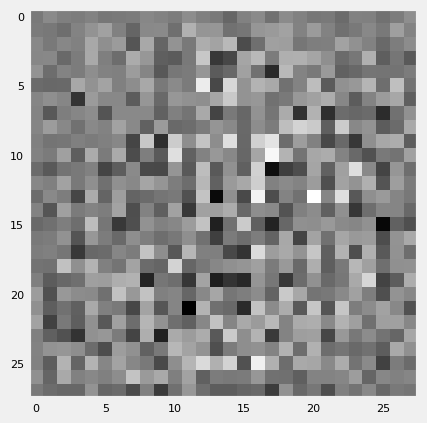

In [6]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.grid(False)
plt.show()

### Дискриминатор

In [7]:
def discriminator_model():
    discriminator_inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(discriminator_inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    
    return keras.Model(discriminator_inputs, x, name='discriminator')

In [8]:
discriminator = discriminator_model()
discriminator.summary()
print(discriminator(generated_image))

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)       

### Функции потерь и оптимизаторы

In [9]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

### Обучение модели

In [13]:
def generate_and_save_images(model, epoch, test_input):
    pred = model(test_input, training=False)

    plt.figure(figsize=(10, 3))
    for i in range(pred.shape[0]):
        plt.subplot(2, 8, i+1)
        plt.imshow(pred[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    img_path = IMAGES_PATH / f'image_at_epoch_{epoch:03}.png'
    plt.savefig(str(img_path))
    plt.show()

In [14]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    for key in ['generator_loss', 'discriminator_loss']:
        plt.plot(history[key], label=key)
        plt.grid(True)
        plt.legend()

    plt.show()

In [15]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [16]:
test_batch = tf.random.normal([16, 100])

def train(dataset, epochs):
    history = {'generator_loss': [],
               'discriminator_loss': []}

    generate_and_save_images(generator, 0, test_batch)
    for epoch in range(epochs):
        start = time()
        epoch_g_loss = 0
        epoch_d_loss = 0

        for batch in dataset:
            g_loss, d_loss = train_step(batch)
            epoch_g_loss += g_loss.numpy()
            epoch_d_loss += d_loss.numpy()

        history['generator_loss'].append(epoch_g_loss / len(dataset))
        history['discriminator_loss'].append(epoch_d_loss / len(dataset))

        clear_output(wait=True)
        print(f'Time for epoch {epoch+1} is {time()-start} sec')
        generate_and_save_images(generator, epoch+1, test_batch)
        plot_history(history)
    
    clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, test_batch)
    plot_history(history)
    return history

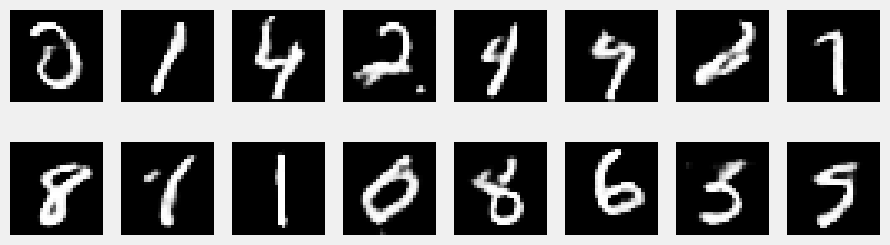

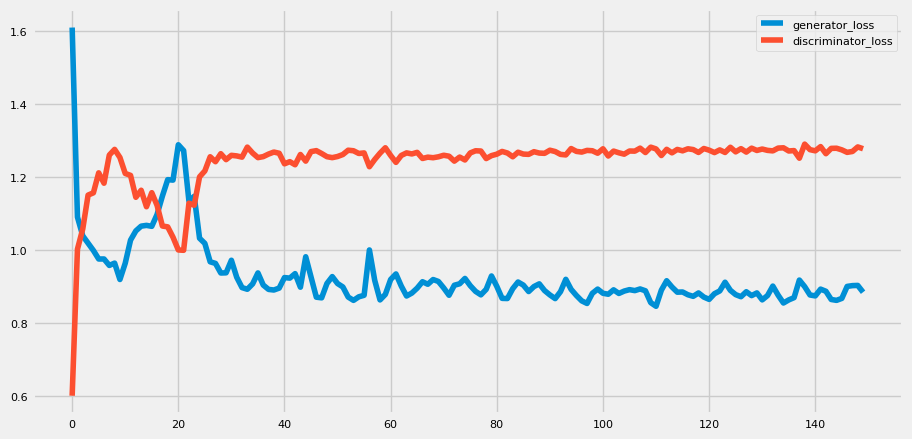

In [17]:
history = train(train_dataset, EPOCHS)

### Создадим гифку с процессом обучения

In [18]:
frames = []
files = IMAGES_PATH.glob('image_at_epoch_*.png')
files = sorted(files)
for file in files:
    frames.append(imageio.v3.imread(file))

imageio.mimsave(GIF_PATH, frames, loop=0)

<img src="images\gan\dcgan.gif" width="750" align="center">